之前我给大家介绍过一篇使用keras和LSTM来进行文本多分类的博客 ,今天我将在google提供的Colab notebook上使用tensorflow2.0来是实现以下中文文本多分类的实战应用。选择Colab notebook是因为在Colab notebook中google提供了免费的GPU资源供你使用，这样可以大大节省模型的训练时间。

Google Colab，全名Colaboratory，是由谷歌提供的免费的云平台，可以使用keras、tensorflow等框架进行深度学习。最近Colab平台已经将K80 GPU更换成Tesla T4 GPU，提供了更强的算力。对于刚入门机器学习或深度学习的用户，这个平台是不二之选。

要使用Google Colab必须要在科学上网的环境下，同时必须要有一个gmail账号，还没有gmail账号的同学请赶快注册一个吧。

如何使用colab请看这篇博客（https://www.cnblogs.com/lfri/p/10471852.html）


In [1]:
%matplotlib inline
import pandas as pd
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import jieba as jb
import re

In [2]:
#如果还没有安装tensorflow2.0,请使用下面的命令安装tensorflow
#!pip install tensorflow==2.0.0

# 数据

In [3]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
print(tf.__version__)

2.17.0


In [4]:
# #加载google的云端硬盘
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
cd /content/drive/MyDrive/Colab Notebooks/text_classfity/data

/content/drive/MyDrive/Colab Notebooks/text_classfity/data


In [6]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/text_classfity/data/online_shopping_10_cats.csv')
print("数据总量: %d ." % len(df))
df.sample(10)

数据总量: 62774 .


,cat,label,review
3390,书籍,0,很可笑吗？没觉得啊，好像这些笑话过时了吧？
44568,衣服,0,不好 裤角好大像80年代的裤子质量不好！总之太假！
43436,衣服,1,质量很好 料子不错 穿上很舒服 蛮暖和的
50503,计算机,1,一、最显著的优点是电池使用时间长；二、配置比较齐全：无线、蓝牙、摄像必备的都有；三、做工还不...
17077,水果,1,颜色不如网站上的红，不知道味道怎样，先吃别的水果，稍后再品尝这个吧。
45464,衣服,0,质量好差，才穿几天，扣子掉了两个
9719,平板,0,用了两周，电量真的无语，买给爸爸用，结果看了两集电视剧就没啥电了，联系客服，人家说 我们这款...
5901,平板,1,还行 刚开始用
49000,计算机,1,外观好看，做工好，散热非常不错，是见过最好的，比想象中的要好，，价格实惠，满意
20256,水果,1,一直吃华圣的苹果，这次选了儿童吃的，打开后水果很新鲜，不知味道咋样，希望宝宝喜欢！


In [7]:
df[["cat"]].drop_duplicates().reset_index(drop=True)

,cat
0,书籍
1,平板
2,手机
3,水果
4,洗发水
5,热水器
6,蒙牛
7,衣服
8,计算机
9,酒店


In [8]:
print(df.cat.value_counts())
print()
print(df.cat.value_counts()/len(df));


cat
平板     10000
水果     10000
酒店     10000
洗发水    10000
衣服     10000
计算机     3992
书籍      3851
手机      2323
蒙牛      2033
热水器      575
Name: count, dtype: int64

cat
平板     0.159302
水果     0.159302
酒店     0.159302
洗发水    0.159302
衣服     0.159302
计算机    0.063593
书籍     0.061347
手机     0.037006
蒙牛     0.032386
热水器    0.009160
Name: count, dtype: float64


In [9]:
df[df.cat=='平板'][["review"]].sample(5).values

array([['帮别人买的，看电影很爽。'],
       ['产品好垃圾，网络连接不了，还不换货，不按国家三包政策，'],
       ['之前在京东买了个小蜜蜂，挂绳的地方一个月不到就断了，蓝牙耳机也没多久都出现问题。想着不值几个钱，没啥大碍就没有说啥。现在想想以后一定要学会维护自己的利益。'],
       ['花泥客服不太好，完全回答不到点子上，还哦哦的让人反感，手机没看到，具体不了解'],
       ['渣渣像素，渣渣分辨率，已经退货']], dtype=object)

In [10]:
df[df.cat=='手机'][["review"]].sample(5).values

array([['1.滑盖的开合动作相当顺畅，力度感不错。2.机身配备了极有创意的触控操作方式，相当舒服。3.做工精巧细致，特别是细节部分做工值得称道。4.画面显示细腻，色彩饱满，所拍图片效果也比较细腻，色彩丰富。'],
       ['外观时尚,功能强大,质量还好'],
       ['设计独特，纯粹的MP3造型,加上轻巧的机身，拿在手里有"一见钟情"的感觉;因为很想买一个MP3!音量、拍摄快捷键很方便平常使用!miniSD插槽支持热插拨,可以下载许多好听的音乐.还有一个USB接口，可以把拍出的照片上传至电脑,利用软件可以自己动手DIY!不但能拍照,画面说得过去;音质还是很好的!前后壳能"变脸",这给心情放个假提供了多好机会!'],
       ['拍照功能十分强劲，便于我平时记录生活，完全足够了～而且，各种型号，同档次200w像素的拍照手机，不管什么牌子，绝对不可能撼动750c“光影捕手”的称号，这个，也是各个论坛都能找到的评测阿对比的。 铃声表现也很巴适，有几首我十分喜欢的，来电铃声，足以强劲，在公车上也拉风的很哦～有网友反映铃声小，可能和mp3原文件有关吧。视频声音有点小，恩，这个有点。游戏，自然不用说了，下了很多很多，仙剑可玩性也很高，超级玛利更是以前小霸王的翻版，呵呵`~~~待机时间我也比较满意的，平日玩手机还是很多，有时传照片插了数据线，就充电一会儿，所以，买了三个多月，充电器充的次数可能小于5次。'],
       ['1.全银色设计很时尚，刚买的时候感觉很有面子，不过现在都兴没天线的了，呵呵2.双屏的，外屏也是带彩的，很漂亮，但是双屏也是费电的根本原因3.语音报号不错，来电话不用看也知道谁是谁了，不想接的直接按了，省事4.铃声好听，音色不错，目前调到最大声，也还行，以前用的那只最大音量就要有爆音了']],
      dtype=object)

In [11]:
df[df.cat=='酒店'][["review"]].sample(5).values

array([['以前名字叫吴宫喜来登，现在改名字了，酒店位置是绝对好的，离开盘门景区是零距离的，住店的客人可以免票进景区的。景区是古色古香的，是古物。现在的酒店的酒店的设施明显是老旧了，下水不是很通畅，水管的水量不是很大的。可能是春节期间，住店客人多，我们是下午2点多道就酒店，等了将近一个小时才有房间的。早上的酒店自助餐和五星级的差距是有点的，品种不是很多的。酒店的游泳池是不错的，是个很好的锻炼的场所。酒店的服务员和管理人员还是很专业的，这个给他们点个赞。希望硬件设施可以得到改善。'],
       ['酒店的环境好，交通也方便，服务人员的素质和态度更是一流！这次去给我们免费升级到商务间，房间又大又漂亮！下次去我们一定还会选择它！'],
       ['环境和设施都不好,提前预订的不靠铁轨的房间没给保留,整晚的火车汽笛声影响了睡眠'],
       ['就是离机场近点，其它都特别差'],
       ['好。。。房间的梳子非常好，现在家里一直用。。下次还得入住，把免费的梳子拿回家。。哈哈哈哈哈。。。地理位置不好，很安静，还算比较好叫出租车，但是周边餐饮基本没有，在一楼餐厅吃了碗西红柿鸡蛋面。。。还不错。。']],
      dtype=object)

In [12]:
df[df.cat=='衣服'][["review"]].sample(5).values

array([['质量不错，面料也很好，满意的一'],
       ['质量很好,穿着舒适,大小合适 款式也很喜欢.是一次满意的网购,有需要的亲们赶快下单哦'],
       ['居然掉色 真心的差劲'],
       ['材质纯棉 很舒服 就是码数感觉要比均码要大些'],
       ['衣服衣料还不错，穿在身上比较舒服']], dtype=object)

## 数据预处理

下面我们要对评语进行一些预处理工作,这包括删除文本中的标点符号,特殊符号,还要删除一些无意义的常用词(stopword),因为这些词和符号对系统分析预测文本的内容没有任何帮助,反而会增加计算的复杂度和增加系统开销,所有在使用这些文本数据之前必须要将它们清理干净。

In [13]:
#定义删除除字母,数字，汉字以外的所有符号的函数
def remove_punctuation(line):
    line = str(line)
    if line.strip()=='':
        return ''
    rule = re.compile(u"[^a-zA-Z0-9\u4E00-\u9FA5]")
    line = rule.sub('',line)
    return line

def stopwordslist(filepath):
    stopwords = [line.strip() for line in open(filepath, 'r', encoding='utf-8').readlines()]
    return stopwords

#加载停用词
stopwords = stopwordslist("/content/drive/MyDrive/Colab Notebooks/text_classfity/data/cn_stopwords.txt")

中文停用词包含了很多日常使用频率很高的常用词,如 吧，吗，呢，啥等一些感叹词等,这些高频常用词无法反应出文本的主要意思,所以要被过滤掉。


In [14]:
df['clean_review'] = df['review'].apply(remove_punctuation)
df.sample(10)

,cat,label,review,clean_review
5360,平板,1,双十一买的，价格优惠，看着够大！,双十一买的价格优惠看着够大
21922,水果,0,个头跟网球一样，甚至更小，超失败的购物，不建议购买,个头跟网球一样甚至更小超失败的购物不建议购买
13054,平板,0,才用了不到半个月，充电中屏就裂了，本身平板就有暗伤。。。联系客服叫我去售后维修，给家里老人买...,才用了不到半个月充电中屏就裂了本身平板就有暗伤联系客服叫我去售后维修给家里老人买的家里那边根...
28529,洗发水,1,没有实体店里的东西好 不知道是不是活动买的还是什么原因 里面稀稀的不是很稠,没有实体店里的东西好不知道是不是活动买的还是什么原因里面稀稀的不是很稠
55348,酒店,1,上帝啊，价格怎么半年就涨了100元？我得回到光大住了。。。不过，作为一个公寓式酒店，蛮值得推...,上帝啊价格怎么半年就涨了100元我得回到光大住了不过作为一个公寓式酒店蛮值得推荐的就是早餐不甚好
27883,洗发水,1,常用沙宣，洗发护理效果不错。搞活动就买点备着。京东送货很快。,常用沙宣洗发护理效果不错搞活动就买点备着京东送货很快
19059,水果,1,一直以来都喜欢在京东购买所有 真的好方便,一直以来都喜欢在京东购买所有真的好方便
52594,计算机,0,装XP有点麻烦，还好我已经有了全新的方法，不用刷BIOS就能安装,装XP有点麻烦还好我已经有了全新的方法不用刷BIOS就能安装
62645,酒店,0,艺龙担保金解冻太慢，离店后3天才退回款，有过意占用客户资金嫌疑。艺龙流程上规定是入住酒店即解...,艺龙担保金解冻太慢离店后3天才退回款有过意占用客户资金嫌疑艺龙流程上规定是入住酒店即解冻担保...
39594,衣服,1,衣服质量很好，保暖也不错，就是袖子的地方容易起球。,衣服质量很好保暖也不错就是袖子的地方容易起球


我们过滤掉了review中的标点符号和一些特殊符号，并生成了一个新的字段 clean_review。接下来我们要在clean_review的基础上进行分词,把每个评论内容分成由空格隔开的一个一个单独的词语。

In [15]:
#分词，并过滤停用词
df['cut_review'] = df['clean_review'].apply(lambda x: " ".join([w for w in list(jb.cut(x)) if w not in stopwords]))
df.head()

Building prefix dict from the default dictionary ...
DEBUG:jieba:Building prefix dict from the default dictionary ...
Dumping model to file cache /tmp/jieba.cache
DEBUG:jieba:Dumping model to file cache /tmp/jieba.cache
Loading model cost 1.419 seconds.
DEBUG:jieba:Loading model cost 1.419 seconds.
Prefix dict has been built successfully.
DEBUG:jieba:Prefix dict has been built successfully.


,cat,label,review,clean_review,cut_review
0,书籍,1,﻿做父母一定要有刘墉这样的心态，不断地学习，不断地进步，不断地给自己补充新鲜血液，让自己保持...,做父母一定要有刘墉这样的心态不断地学习不断地进步不断地给自己补充新鲜血液让自己保持一颗年轻的...,做 父母 一定 刘墉 心态 不断 学习 不断 进步 不断 补充 新鲜血液 保持 一颗 年轻 ...
1,书籍,1,作者真有英国人严谨的风格，提出观点、进行论述论证，尽管本人对物理学了解不深，但是仍然能感受到...,作者真有英国人严谨的风格提出观点进行论述论证尽管本人对物理学了解不深但是仍然能感受到真理的火...,作者 真有 英国人 严谨 风格 提出 观点 进行 论述 论证 物理学 了解 不深 仍然 感受...
2,书籍,1,作者长篇大论借用详细报告数据处理工作和计算结果支持其新观点。为什么荷兰曾经县有欧洲最高的生产...,作者长篇大论借用详细报告数据处理工作和计算结果支持其新观点为什么荷兰曾经县有欧洲最高的生产率...,作者 长篇大论 借用 详细 报告 数据处理 工作 计算结果 支持 其新 观点 荷兰 曾经 县...
3,书籍,1,作者在战几时之前用了＂拥抱＂令人叫绝．日本如果没有战败，就有会有美军的占领，没胡官僚主义的延...,作者在战几时之前用了拥抱令人叫绝日本如果没有战败就有会有美军的占领没胡官僚主义的延续没有战后...,作者 战 之前 拥抱 令人 叫绝 日本 没有 战败 会 美军 占领 没胡 官僚主义 延续 没...
4,书籍,1,作者在少年时即喜阅读，能看出他精读了无数经典，因而他有一个庞大的内心世界。他的作品最难能可贵...,作者在少年时即喜阅读能看出他精读了无数经典因而他有一个庞大的内心世界他的作品最难能可贵的有两...,作者 少年 时即 喜 阅读 看出 精读 无数 经典 一个 庞大 内心世界 作品 难能可贵 两...


# 建模

 首先我们要数据集中拆分出训练集和验证集,我们将80%的数据作为训练集,20%的数据作为验证集，我们通过分层抽样的方式来随机抽样，注意在这里我们使用了sklearn的train_test_split的方法来抽样,并使用了stratify参数来保证抽样后,训练集和验证集中的各个类目的占比与原数据集保持一致。

In [16]:
#拆分训练集和测试集
X_train, X_validation, Y_train, Y_validation = train_test_split(df[['cut_review']],df[["cat"]], test_size = 0.2,stratify=df.cat)
print(len(X_train))
print(len(X_validation))

50219
12555


In [17]:
Y_train.cat.value_counts()/len(Y_train)

,count
cat,
衣服,0.159302
酒店,0.159302
平板,0.159302
水果,0.159302
洗发水,0.159302
计算机,0.063601
书籍,0.061351
手机,0.036998
蒙牛,0.032378


In [18]:
Y_validation.cat.value_counts()/len(Y_validation)

,count
cat,
洗发水,0.159299
水果,0.159299
酒店,0.159299
平板,0.159299
衣服,0.159299
计算机,0.063560
书籍,0.061330
手机,0.037037
蒙牛,0.032417


In [19]:

vocab_size = 5000
embedding_dim = 64
max_length = 150
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>'

In [20]:
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(X_train.cut_review.values)
word_index = tokenizer.word_index
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

In [21]:
print(len(list(word_index.items())))
print()
list(word_index.items())[:10]

62310



[('<OOV>', 1),
 ('买', 2),
 ('不错', 3),
 ('没有', 4),
 ('酒店', 5),
 ('京东', 6),
 ('说', 7),
 ('房间', 8),
 ('非常', 9),
 ('一个', 10)]

In [22]:
X_train_sequences = tokenizer.texts_to_sequences(X_train.cut_review.values)
X_train_padded = pad_sequences(X_train_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

X_validation_sequences = tokenizer.texts_to_sequences(X_validation.cut_review.values)
X_validation_padded = pad_sequences(X_validation_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)



In [23]:
index = 10
print(X_train.cut_review.values[index])
print()
print(X_train_sequences[index])
print()
X_train_padded[index]


推行 环保 方面 做 比较 到位 菱湖 公园 旁边 环境 不错 总体 房间 稍微 偏小 一点

[1, 1, 259, 104, 15, 740, 1, 1753, 632, 118, 3, 162, 8, 552, 1549, 54]



array([   1,    1,  259,  104,   15,  740,    1, 1753,  632,  118,    3,
        162,    8,  552, 1549,   54,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0], d

In [24]:
print("104 ->",reverse_word_index[104])
print("3 ->",reverse_word_index[3])
print("120 ->",reverse_word_index[120])
print()
print("贴身 ->",dict(list(word_index.items()))["贴身"])
print("1 ->",reverse_word_index[1])


104 -> 做
3 -> 不错
120 -> 好评

贴身 -> 7858
1 -> <OOV>


In [25]:
label_tokenizer = Tokenizer()
label_tokenizer.fit_on_texts(df.cat.values)

Y_training_cat_seq = np.array(label_tokenizer.texts_to_sequences(Y_train.cat.values))
Y_validation_cat_seq = np.array(label_tokenizer.texts_to_sequences(Y_validation.cat.values))

label_word_index = label_tokenizer.word_index

print(dict(list(label_word_index.items())))
print(Y_training_cat_seq.shape)
print()
print(Y_training_cat_seq[0])
print(Y_training_cat_seq[1])
print(Y_training_cat_seq[2])


{'平板': 1, '水果': 2, '洗发水': 3, '衣服': 4, '酒店': 5, '计算机': 6, '书籍': 7, '手机': 8, '蒙牛': 9, '热水器': 10}
(50219, 1)

[4]
[5]
[4]


In [26]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_article(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])
print(decode_article(X_train_padded[0]))
print('------------------------------------------------')
print(X_train.cut_review.values[0])

说 物流 慢 要死 本来 想 京东 快递 快 t 慢 平时 天 左右 竟然 张 这么久 ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ?
------------------------------------------------
说 物流 慢 要死 本来 想 京东 快递 快 t 慢 平时 天 左右 竟然 张 这么久


In [27]:
model = tf.keras.Sequential([

    tf.keras.layers.Embedding(vocab_size, embedding_dim),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim)),
    tf.keras.layers.Dense(embedding_dim, activation='relu'),
    tf.keras.layers.Dense(11, activation='softmax')
])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [28]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [29]:
num_epochs = 10
history = model.fit(X_train_padded,
                    Y_training_cat_seq,
                    epochs=num_epochs,
                    validation_data=(X_validation_padded, Y_validation_cat_seq),
                    verbose=2)

Epoch 1/10
1570/1570 - 27s - 17ms/step - accuracy: 0.7863 - loss: 0.6138 - val_accuracy: 0.8718 - val_loss: 0.3686
Epoch 2/10
1570/1570 - 23s - 14ms/step - accuracy: 0.8927 - loss: 0.3108 - val_accuracy: 0.8820 - val_loss: 0.3355
Epoch 3/10
1570/1570 - 39s - 25ms/step - accuracy: 0.9104 - loss: 0.2559 - val_accuracy: 0.8816 - val_loss: 0.3356
Epoch 4/10
1570/1570 - 41s - 26ms/step - accuracy: 0.9212 - loss: 0.2198 - val_accuracy: 0.8804 - val_loss: 0.3557
Epoch 5/10
1570/1570 - 42s - 27ms/step - accuracy: 0.9297 - loss: 0.1958 - val_accuracy: 0.8814 - val_loss: 0.3587
Epoch 6/10
1570/1570 - 41s - 26ms/step - accuracy: 0.9360 - loss: 0.1744 - val_accuracy: 0.8769 - val_loss: 0.3935
Epoch 7/10
1570/1570 - 41s - 26ms/step - accuracy: 0.9432 - loss: 0.1590 - val_accuracy: 0.8790 - val_loss: 0.3966
Epoch 8/10
1570/1570 - 41s - 26ms/step - accuracy: 0.9474 - loss: 0.1422 - val_accuracy: 0.8790 - val_loss: 0.4277
Epoch 9/10
1570/1570 - 20s - 13ms/step - accuracy: 0.9535 - loss: 0.1274 - val_a

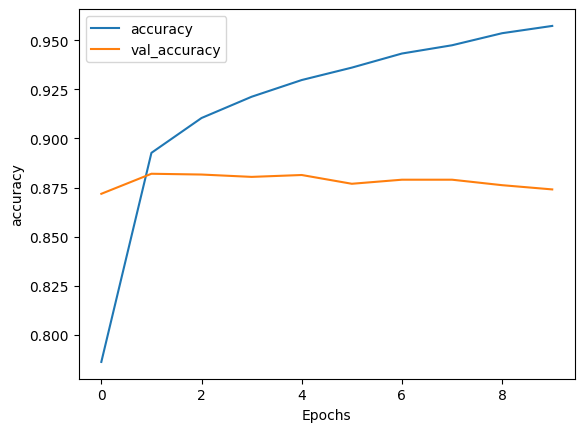

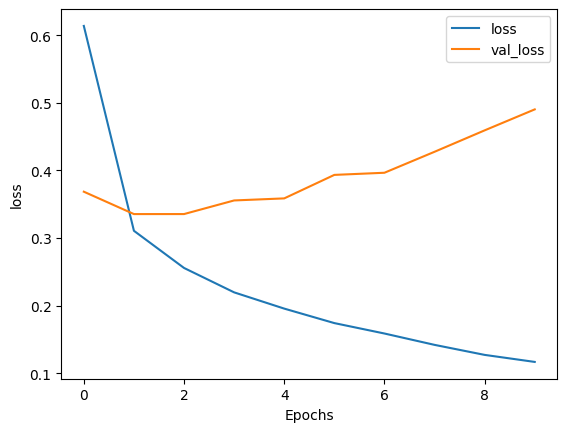

In [30]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [31]:
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix

y_pred = model.predict(X_validation_padded)
y_pred = y_pred.argmax(axis = 1)


393/393 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step


{'平板': 1, '水果': 2, '洗发水': 3, '衣服': 4, '酒店': 5, '计算机': 6, '书籍': 7, '手机': 8, '蒙牛': 9, '热水器': 10}


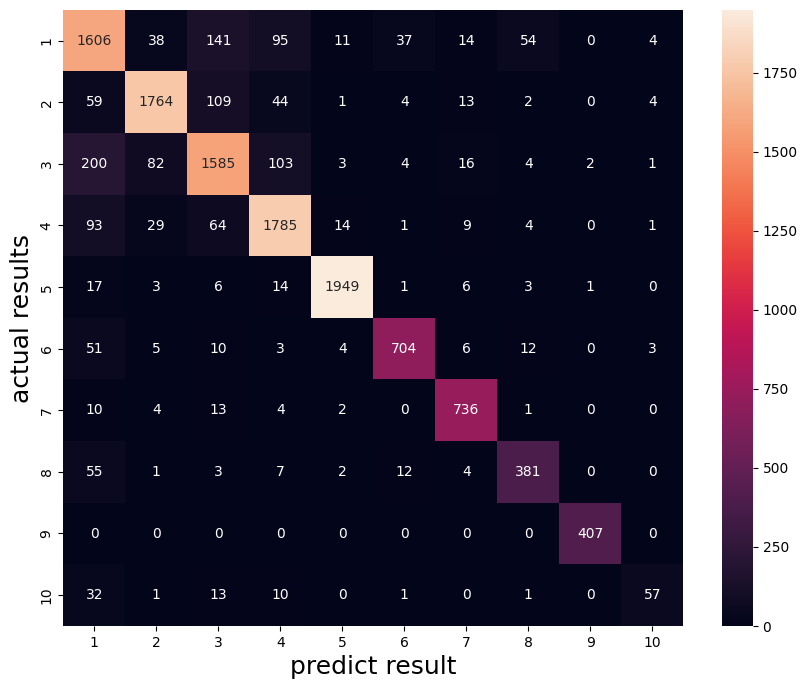

In [32]:
labels=[1,2,3,4,5,6,7,8,9,10]
conf_mat = confusion_matrix(Y_validation_cat_seq, y_pred)
fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(conf_mat, annot=True, fmt='d',xticklabels=labels, yticklabels=labels)
plt.ylabel('actual results',fontsize=18);
plt.xlabel('predict result',fontsize=18);
print(dict(list(label_word_index.items())))



In [33]:
from  sklearn.metrics import classification_report
print('accuracy %s' % accuracy_score(y_pred, Y_validation_cat_seq))
print(classification_report(Y_validation_cat_seq, y_pred,target_names=[str(w) for w in labels]))
print(dict(list(label_word_index.items())))

accuracy 0.8740740740740741
              precision    recall  f1-score   support

           1       0.76      0.80      0.78      2000
           2       0.92      0.88      0.90      2000
           3       0.82      0.79      0.80      2000
           4       0.86      0.89      0.88      2000
           5       0.98      0.97      0.98      2000
           6       0.92      0.88      0.90       798
           7       0.92      0.96      0.94       770
           8       0.82      0.82      0.82       465
           9       0.99      1.00      1.00       407
          10       0.81      0.50      0.62       115

    accuracy                           0.87     12555
   macro avg       0.88      0.85      0.86     12555
weighted avg       0.88      0.87      0.87     12555

{'平板': 1, '水果': 2, '洗发水': 3, '衣服': 4, '酒店': 5, '计算机': 6, '书籍': 7, '手机': 8, '蒙牛': 9, '热水器': 10}
